# Text Classification with Tensorflow

<hr>

This notebook has a [PyTorch version](./../text_classification.ipynb), with more detailed explanations.



### Getting the Dataset and Tokenizer

First, we need to prepare our dataset and our tokenizer

In [1]:
from datasets import load_dataset

# Load the emotion dataset
emotions = load_dataset("emotion")

No config specified, defaulting to: emotion/split
Found cached dataset emotion (C:/Users/andsfonseca/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
from transformers import DistilBertTokenizer

# Load the DistilBertTokenizer tokenizer 
model_ckpt = "distilbert-base-uncased"
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [3]:
# A processing function to tokenize our dataset
def tokenize(batch):
    return distilbert_tokenizer(batch["text"], padding=True, truncation=True)

In [4]:
# Apply it across all the splits in the dataset
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Loading cached processed dataset at C:\Users\andsfonseca\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-af7a5740def0737e.arrow
Loading cached processed dataset at C:\Users\andsfonseca\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-c1b55556f1386ef3.arrow
Loading cached processed dataset at C:\Users\andsfonseca\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-4ffa6baf4d9e676c.arrow


## Training a Text Classifier

We have two options to train such a model on our Twitter dataset:

* Feature extraction

    We use the hidden states as features and just train a classifier on them, without modifying the pretrained model.

* Fine-tuning

    We train the whole model end-to-end, which also updates the parameters of the pretrained model.


### Transformers as Feature Extractor

Using a transformer as a feature extractor is fairly simple. We freeze the body’s weights during training and use the hidden states as features for the classifier.

#### Using pretrained models

The TFAutoModel has a from_pretrained() method to load the weights of a pretrained model. Let’s use this method to load the [DistilBERT](https://huggingface.co/distilbert-base-uncased-distilled-squad) checkpoint:

In [5]:
from transformers import TFAutoModel

In [6]:
model_ckpt = "distilbert-base-uncased"
model = TFAutoModel.from_pretrained(model_ckpt)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


#### Extracting the last hidden states

In [7]:
import tensorflow as tf

# device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'
device = '/CPU:0'

In [8]:
# Apply in the whole dataset creating a new hidden_state column that stores all these vectors. 
def extract_hidden_states(batch):

    # Place model inputs on the device
    inputs = {k: tf.identity(v) for k,v in batch.items() if k in distilbert_tokenizer.model_input_names}

    with tf.device(device), tf.GradientTape() as tape:
        tape.stop_recording()
        last_hidden_state = model(inputs).last_hidden_state
        
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].numpy()}

In [9]:
emotions_encoded.set_format("tensorflow", columns=["input_ids", "attention_mask", "label"])

In [10]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True, batch_size=32)

INFO:tensorflow:Assets written to: ram://4e003535-443e-47ab-88a3-08cea9f98941/assets


INFO:tensorflow:Assets written to: ram://4e003535-443e-47ab-88a3-08cea9f98941/assets


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

INFO:tensorflow:Assets written to: ram://ffffd767-9999-49e3-9e00-d3ebd34194f7/assets


INFO:tensorflow:Assets written to: ram://ffffd767-9999-49e3-9e00-d3ebd34194f7/assets


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

INFO:tensorflow:Assets written to: ram://2ef73003-7529-4d13-8e2d-0763edf67f31/assets


INFO:tensorflow:Assets written to: ram://2ef73003-7529-4d13-8e2d-0763edf67f31/assets


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

#### Creating a feature matrix and visualize the training set

In [11]:
import numpy as np

# Create the corresponding arrays in the well-known Scikit-learn format
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

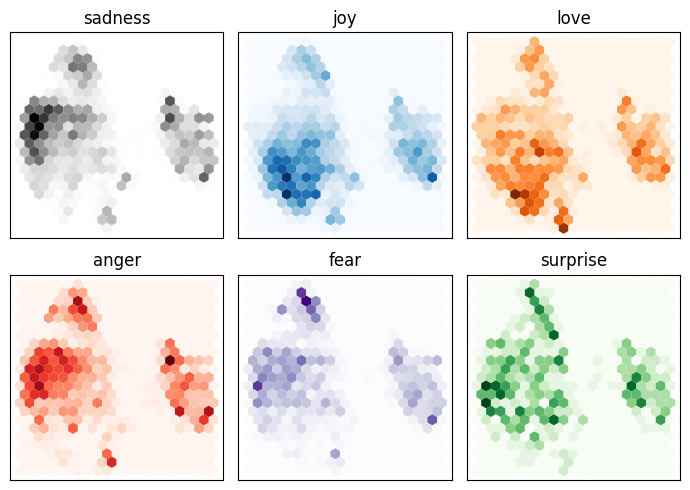

In [12]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

# Showing the compressed data and plot the density of points for each category separately
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
    gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
    
plt.tight_layout()
plt.show()

#### Training a simple classifier

In [13]:
from sklearn.linear_model import LogisticRegression

# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6335

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Let's investigate the performance of the model by looking at the confusion matrix of the classifier
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

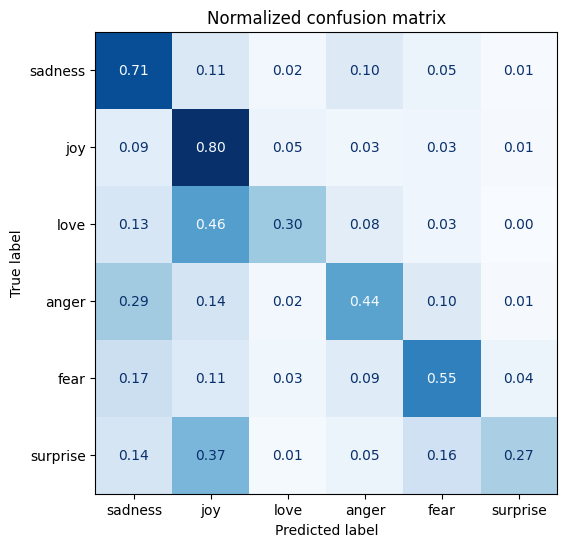

In [15]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

### Fine-Tuning Transformers

With the fine-tuning approach we do not use the hidden states as fixed features, but instead train them.

#### Loading a pretrained model

The first thing we need is a pretrained DistilBERT model like the one we used in the feature-based approach. 

In [16]:
from transformers import TFAutoModelForSequenceClassification

In [17]:
num_labels = 6
model = (TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels))

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_38', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [18]:
# Convert our datasets into the tf.data.Dataset format
tokenizer_columns = distilbert_tokenizer.model_input_names
with tf.device(device):
    tf_train_dataset = emotions_encoded["train"].to_tf_dataset( columns=tokenizer_columns, label_cols=["label"], shuffle=True, batch_size=16)
    tf_eval_dataset = emotions_encoded["validation"].to_tf_dataset(columns=tokenizer_columns, label_cols=["label"], shuffle=False, batch_size=16)

#### Training the model

In [19]:
# The last thing to do is compile and train the model
with tf.device(device):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=tf.metrics.SparseCategoricalAccuracy())

    history = model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=2)

Epoch 1/2
1000/1000 [==============================] - 2504s 2s/step - loss: 0.3843 - sparse_categorical_accuracy: 0.8686 - val_loss: 0.1943 - val_sparse_categorical_accuracy: 0.9190
Epoch 2/2
1000/1000 [==============================] - 2506s 3s/step - loss: 0.1396 - sparse_categorical_accuracy: 0.9401 - val_loss: 0.1440 - val_sparse_categorical_accuracy: 0.9340


In [20]:
preds_output = model.predict(tf_eval_dataset)

125/125 [==============================] - 16s 111ms/step


In [23]:
# We can decode the predictions greedily using np.argmax().
y_preds = np.argmax(preds_output.logits, axis=1)

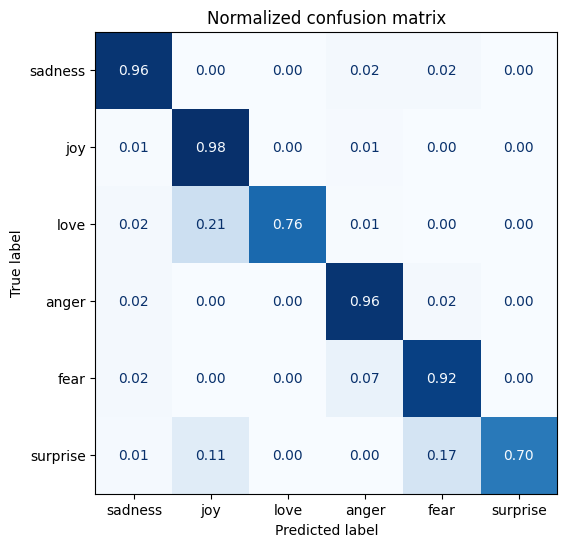

In [24]:
# We can take a more detailed look at the training metrics by calculating the confusion matrix.
plot_confusion_matrix(y_preds, y_valid, labels)